##PINN:

In [1]:
import time
import math
import numpy as np
from problems import second_order
from pinn import PINN, make_points
from plots_and_stats import plot_errors, plot_comparison
np.random.seed(1234)

alpha = -0.500, beta = 0.000, k = 0.707, w = 0.200, x0 = -10.000, th0 = 0.000


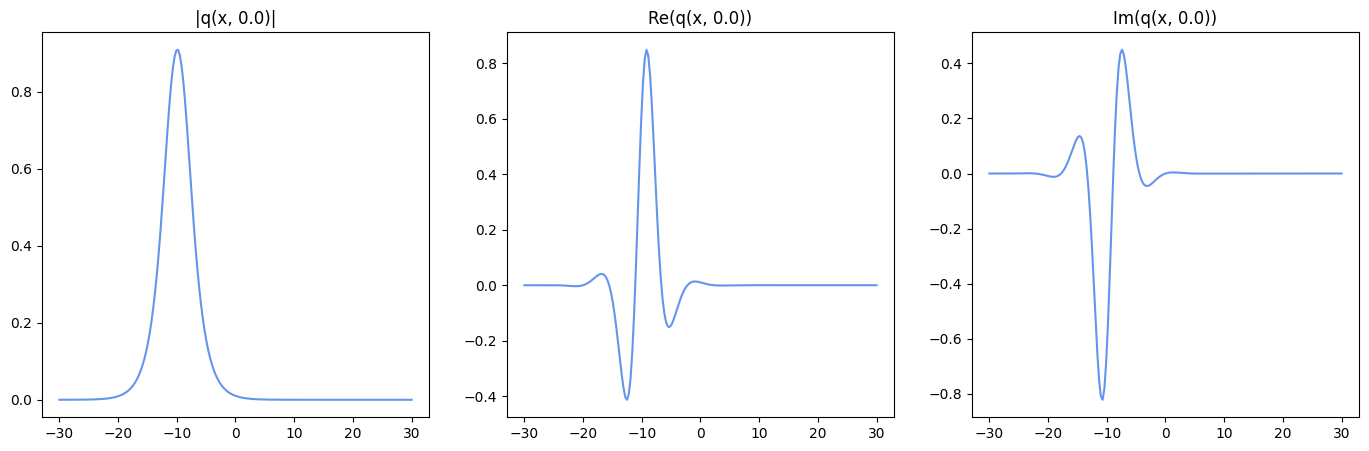

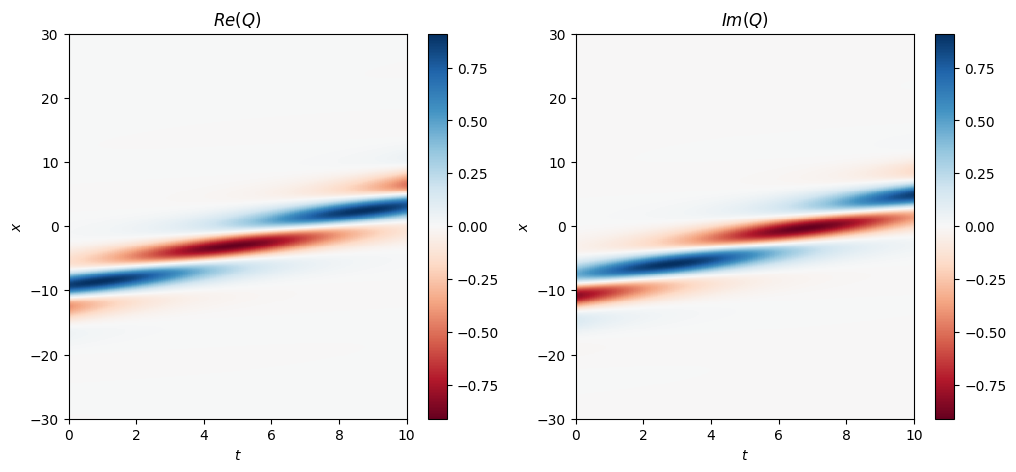

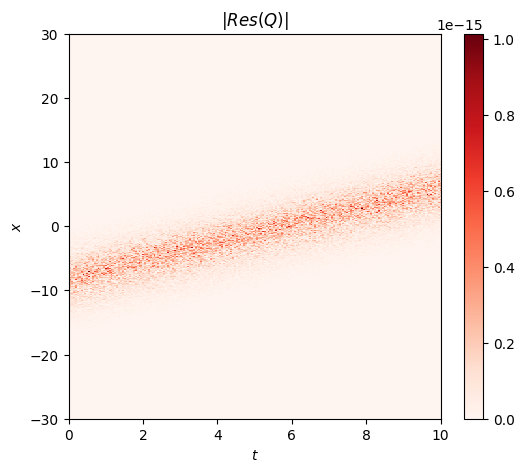

In [2]:
#domain setting
x_0=-30.
x_1=30.
t_0=0.
t_1=10.
#problem setting
alpha = -0.5
beta = 0.0
k = 0.707
w = 0.2
x0_param = -10.0
th0 = 0.0
problem = second_order(x_0, x_1, t_0, t_1, alpha, beta, k, w, x0_param, th0)
#info about the problem
problem.show_params()
problem.show_ic(x_resolution=200)
problem.show_solution(x_resolution=400, t_resolution=200, show_residual=True)

In [3]:
#data for training
X_i_train, U_i_train, V_i_train, X_b_train, X_grid = make_points(problem, init_points_amt=400, bound_points_amt=200, grid_resolution_x=400, grid_resolution_t=100)
#data for metrics evaluation
x_parts=300
t_parts=200
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #test input for PINN
Q_truth=problem.q(X,T) #ground truth
layers = [2, 100, 100, 100, 2] #network topology

In [ ]:
%%time
model = PINN(problem, layers, X_i_train, U_i_train, V_i_train, X_b_train, X_grid)
##Setting hyperparameters
#verbosity
model.verbosity = 10000 #loss output frequency
model.make_res_gif = False #makes gif with residual history
#points generation options
model.points_gen_method = "random" #"random"/first"/"second"/"third"
model.points_gen_freq = 10 #points generation frequency
model.points_am = 10000 #amount of collocation points
#optimization options
model.adam_steps = 400000
model.lbfgs_steps = 10
model.nncg_steps = 0
model.adam_step_decay = 0.999
model.lbfgs_step_decay = 0.990
model.nncg_step_decay = 0.990
model.decay_freq = 100
#loss balancing options
model.loss_bal_method = "none" #"none"/"relobralo"
model.bal_freq = 1000 #loss rebalancing frequency
model.lambda_i = 950/1000
model.lambda_b = 49/1000
model.lambda_f = 1/1000
model.extinction = 0.37 #extinction coefficient for ReLoBRaLo
#causal training
model.causal_loss = False
model.epsilon = 0.79
model.t_partition = 50 #number of parts in the [t_0, t_1] division

model.train()

Training started with random points generation method and none loss balancing
400000 steps of ADAM:
Iter 10000, Loss: 2.199e-05, Loss_i: 1.35e-05, Loss_b: 1.48e-05, Loss_f: 8.42e-03
Iter 20000, Loss: 1.621e-05, Loss_i: 7.58e-06, Loss_b: 1.98e-05, Loss_f: 8.04e-03
Iter 30000, Loss: 7.566e-06, Loss_i: 8.18e-07, Loss_b: 5.98e-06, Loss_f: 6.50e-03


In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
torch.save(model, f'model(2nd_order).pth')
#model = torch.load(f'model(2nd_order).pth', map_location=device)

/tmp/ipykernel_8989/1143887717.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'model(2nd_order).pth', map_location=device)


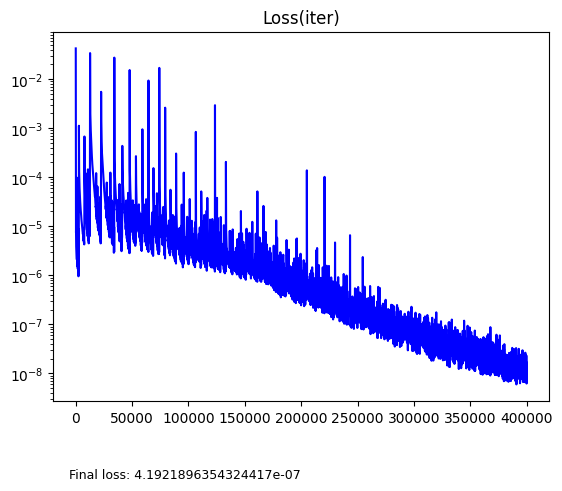

In [5]:
model.train_hist(logscale=True, step=100)

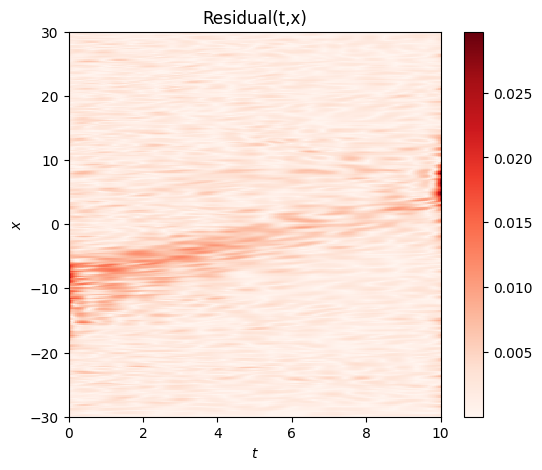

In [6]:
model.plot_residual(X, T)

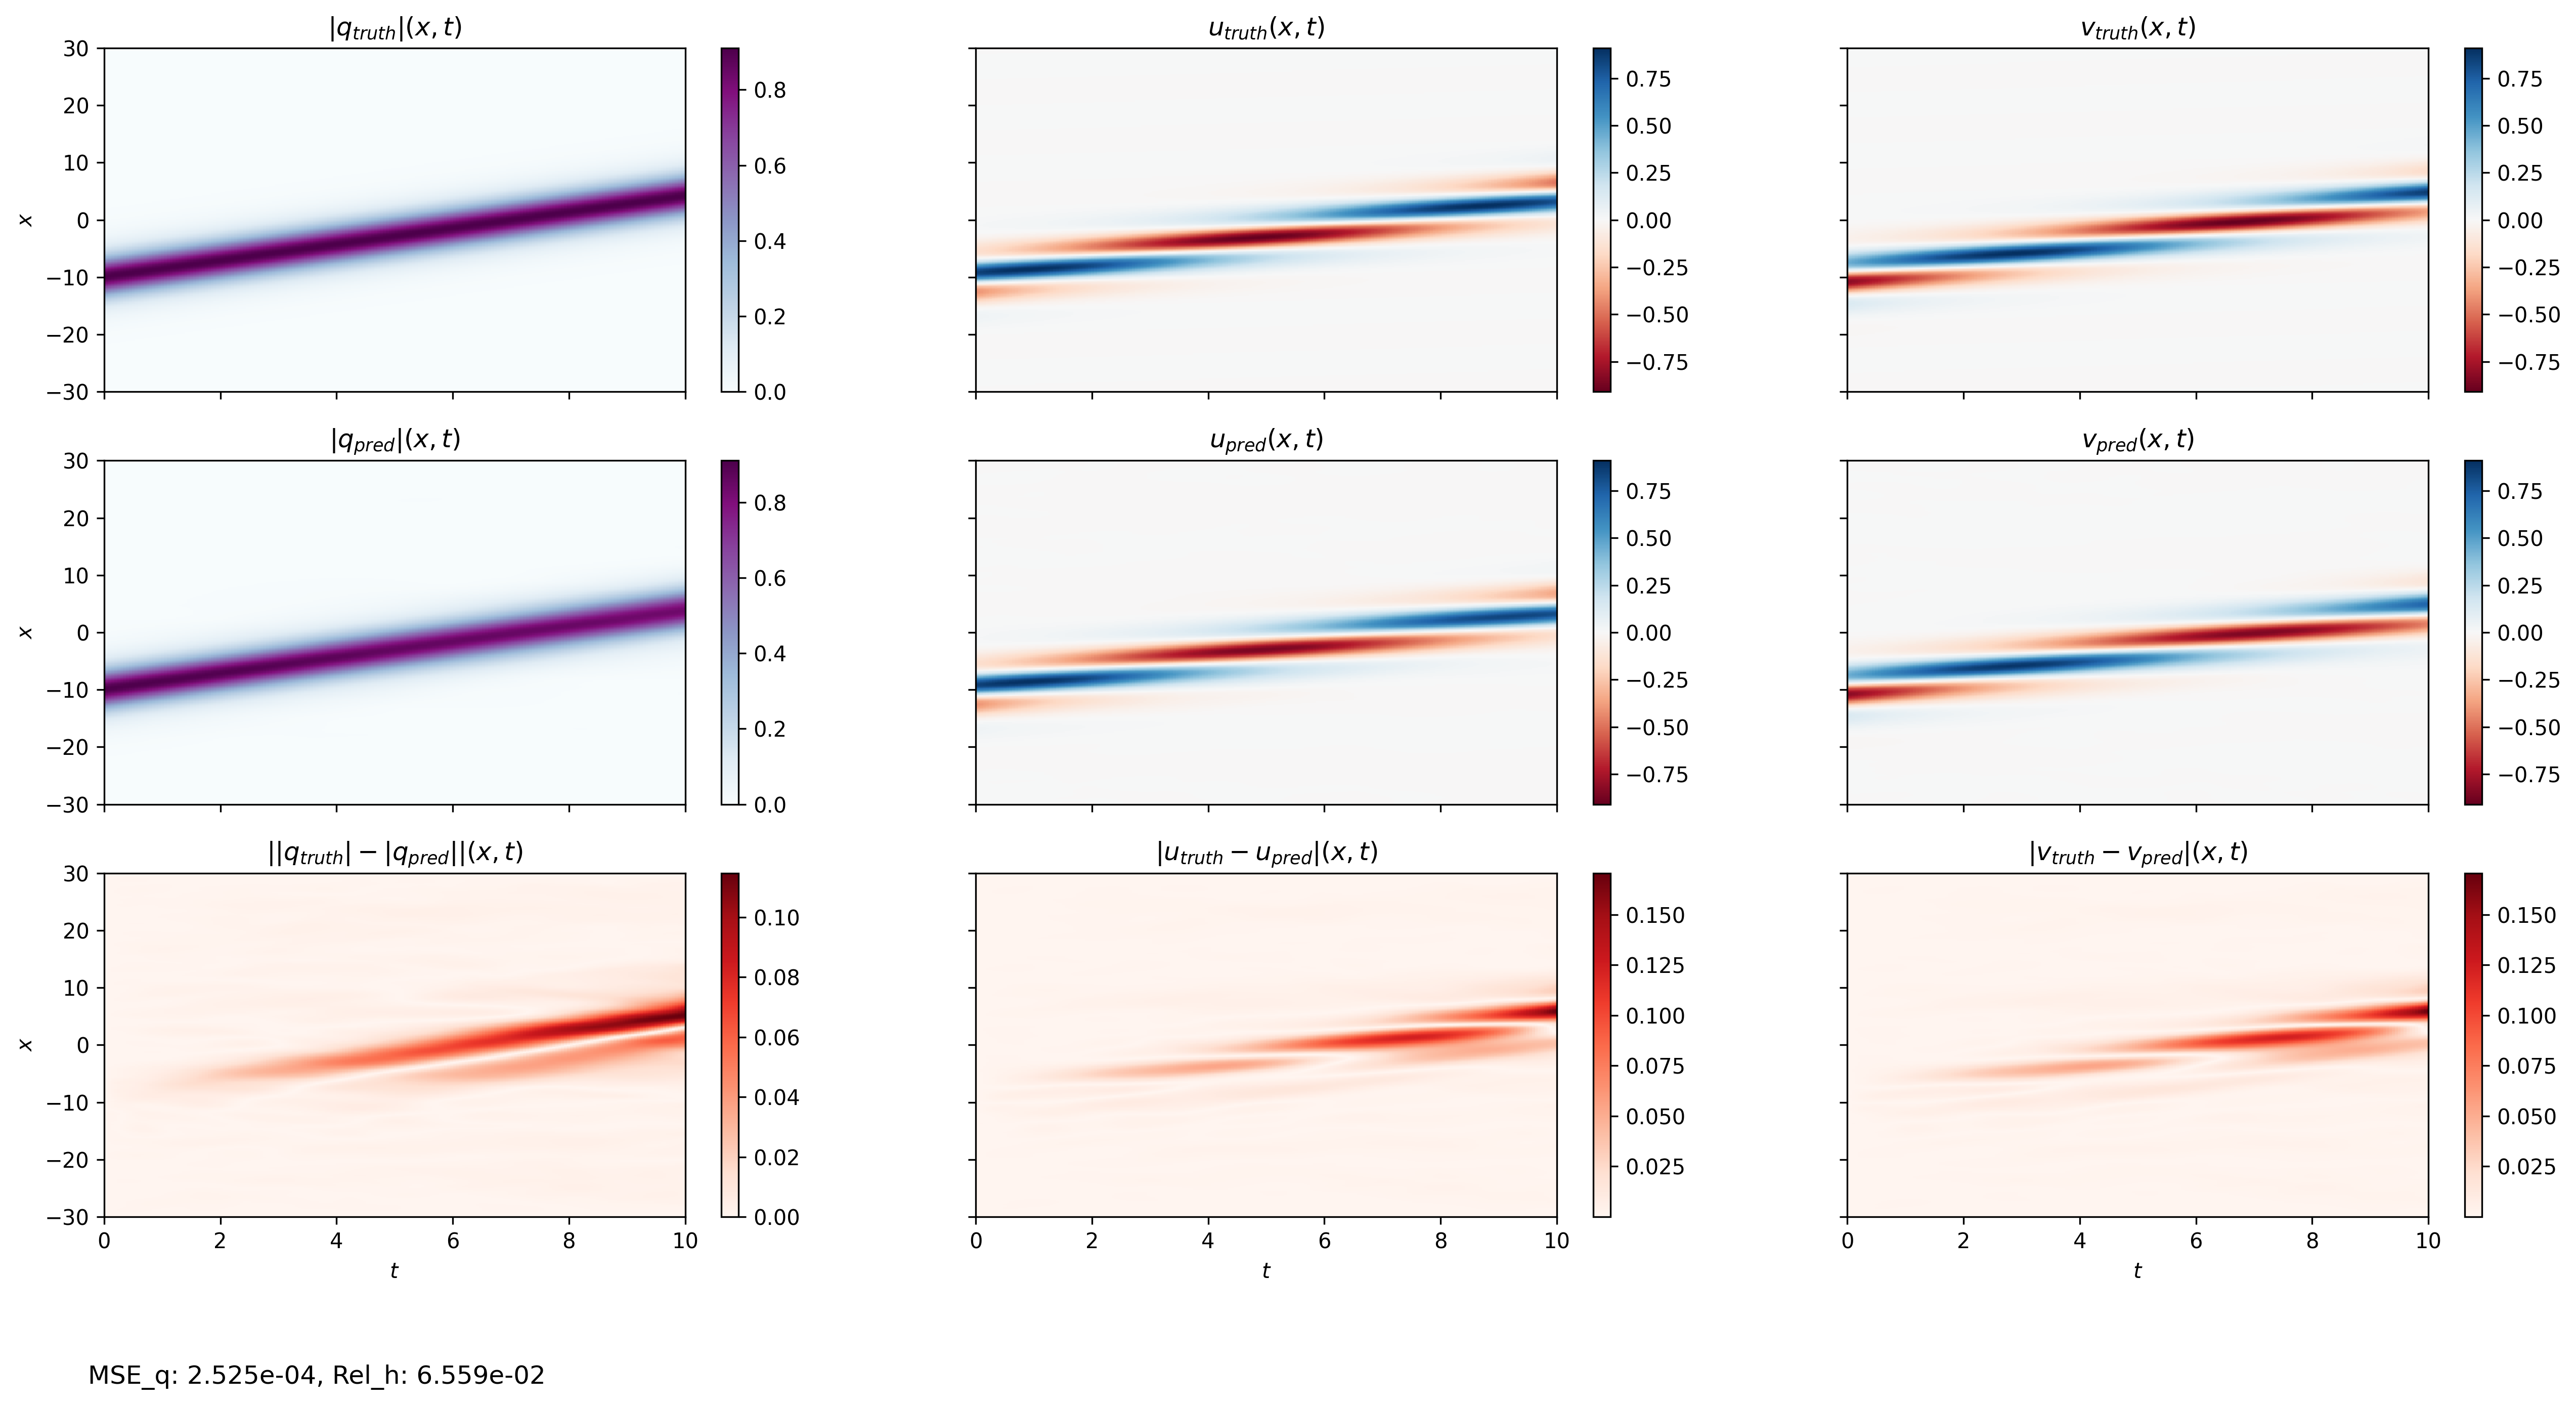

{'MSE_q': 0.00025251162017425757, 'Rel_h': 0.06559095686402018}

In [7]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
Q_pred=u_pred.reshape((t_parts, x_parts)) + 1j*v_pred.reshape((t_parts, x_parts))
plot_comparison(X, T, Q_pred, Q_truth, savefig=True, namefig="test_comparison(2nd_order).png")

Dimensionality by x: 300, by t: 200


{'Lw1_per_max': 11.106329395450395,
 'Lw1_per_mean': 6.874444693813555,
 'Lw2_per_max': 13.873256664793665,
 'Lw2_per_mean': 8.717259028517581,
 'Rel_h': 0.06559095686402018}

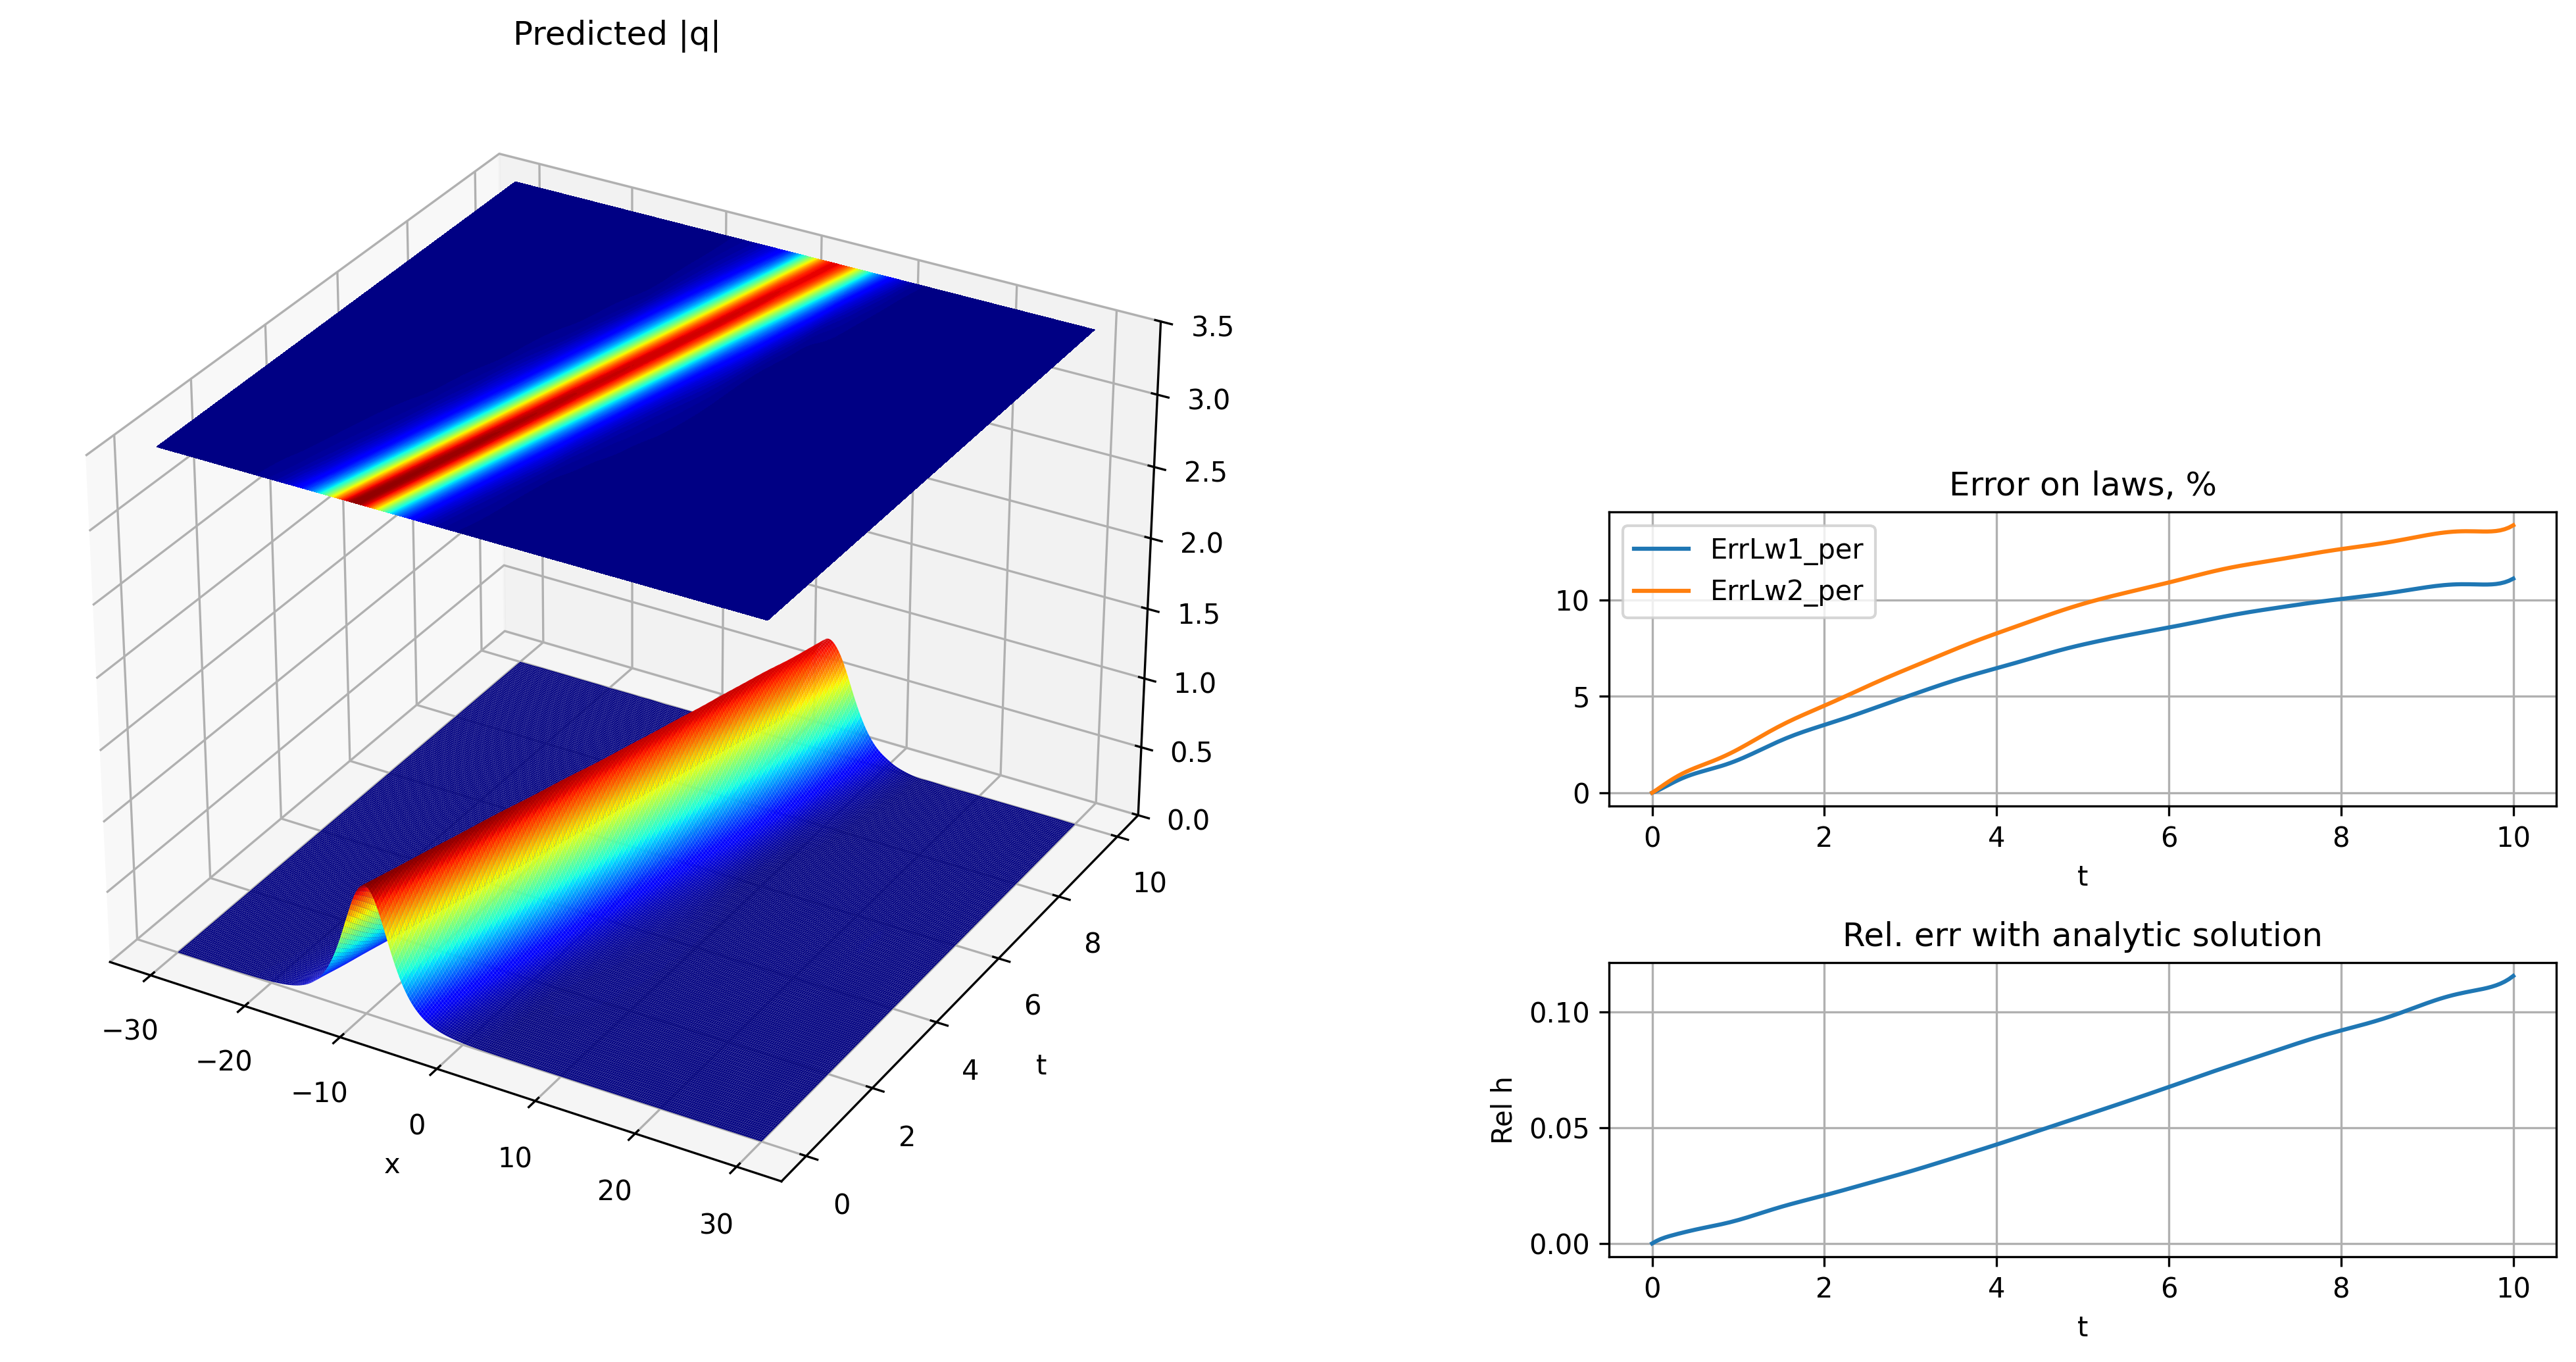

In [8]:
plot_errors(X, T, Q_pred, Q_truth, savefig=True, namefig="test_errors(2nd_order).png", savetable=False, nametable="data(2nd_order).csv")